In [1]:
import numpy as np
import pandas as pd


from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from psql_functions import execQuery
from miss_data import add_missing_dates, add_missing_counts
from make_plots import dict_error_plot_epsilons, dict_error_plot_n

import warnings
warnings.filterwarnings('ignore')

import sys
import os
import re
owd = os.getcwd()

In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

query = """select count_ from _775147;"""
result = execQuery(param_dic, query)

counts = [(count[0]) for count in result]

all_dates = add_missing_dates(dates)
all_counts =  add_missing_counts(counts, dates, all_dates)

n_data_structures = 50


Executed query and closed connection.
Executed query and closed connection.


In [3]:
onlydirs = [f for f in os.listdir(os.getcwd()) if os.path.isdir(os.path.join(os.getcwd(), f)) and f[0] != '.']

In [4]:
onlydirs

['Data', 'plots', 'range_queries', 'results', '__pycache__']

In [5]:
def make_lookup_error_dict_n_degree(epsilons, n, degrees):
    epsilon_dict = dict.fromkeys(epsilons)
    n_dicts = []
    for i in range(0,len(epsilons)):
        n_dict = dict.fromkeys(n)
        n_dicts.append(n_dict)
    degree_dicts = []
    for i in range(0,len(n)*len(epsilons)):
        degree_dict = dict.fromkeys(degrees)

        degree_dicts.append(degree_dict)
    i = 0
    j = 0
    for e_key in epsilon_dict:
        #print(e_key)
        epsilon_dict[e_key] = n_dicts[i]
        n_dict = epsilon_dict[e_key]
        #print(epsilon_dict[e_key])
        for n_key in n_dict:
            n_dict[n_key] = degree_dicts[j]
            j = j + 1
        i = i + 1
        #print(epsilon_dict)
    return epsilon_dict


def fill_up_lookup_error_dict_n_degree(epsilons, n, degrees, files):
    dict_ = make_lookup_error_dict_n_degree(epsilons, n, degrees)
    for idx, f in enumerate(files):
        e = re.search(r'e=[-+]?[0-9]*\.?[0-9]*', f).group(0)
        e = e.split("e=")[1]
        here_n = re.search(r'N=\d+', f).group(0)
        here_n = here_n.split("N=")[1]
        here_degree = re.search(r'B=\d+', f).group(0) 
        here_degree = here_degree.split("B=")[1]

        dict_[float(e)][int(here_n)][int(here_degree)] = np.loadtxt(f, delimiter=',')
    return dict_

def find_error_different_queries(est, cor):
    erorrs = est - cor
    max_error = np.amax(erorrs)
    min_error = np.amin(erorrs)
    rmse = mean_squared_error(cor, est, squared = False)
    error_dict = {'rmse': rmse, 'max': max_error, 'min': min_error, 'abs': np.mean(erorrs)}
    return error_dict

In [6]:
epsilons = np.array([2, 1.4, 1.2, 1, 0.8, 0.6, 0.5, 0.3])
n = np.array([32,128,256,512,1024,2048])
degrees = np.array([2,3,4])

# Loading the data from the hierarchical Histogram model

In [7]:
#C:\Users\Jonas Friis\Documents\Universitet\Bachelors-Thesis\src\results\sample_querys\local_hh
os.chdir(os.getcwd()+'/'+'results/sample_querys/local_hh/')
os.getcwd()

'C:\\Users\\Jonas Friis\\Documents\\Universitet\\Bachelors-Thesis\\src\\results\\sample_querys\\local_hh'

In [8]:
hh_files = [f for f in os.listdir('.')]
hh_files_cor = hh_files[:len(hh_files)//2]
hh_files_est = hh_files[len(hh_files)//2:]
#print(hh_files_cor)
#print(hh_files_est)
#Where flat beats hh
hh_files_cor_flat = hh_files_cor[:144]
#Where hh beats flat
hh_files_cor_hh = hh_files_cor[144+1:]
#print(hh_files_cor_flat)
#print(hh_files_cor_hh)
hh_files_est = hh_files[len(hh_files)//2:]
hh_files_est_flat = hh_files_est[:144]
hh_files_est_hh = hh_files_est[144+1:]
#print(hh_files_est_flat)
#print(hh_files_est_hh)

In [9]:
hh_cor_flat_dict = fill_up_lookup_error_dict_n_degree(epsilons, n, degrees, hh_files_cor_flat)
hh_cor_hh_dict = fill_up_lookup_error_dict_n_degree(epsilons, n, degrees, hh_files_cor_hh)

hh_est_flat_dict = fill_up_lookup_error_dict_n_degree(epsilons, n, degrees, hh_files_est_flat)
hh_est_hh_dict = fill_up_lookup_error_dict_n_degree(epsilons, n, degrees, hh_files_est_hh)

In [10]:
hh_cor_hh_dict

{2.0: {32: {2: array([], dtype=float64),
   3: array([], dtype=float64),
   4: array([], dtype=float64)},
  128: {2: array([], dtype=float64),
   3: array([], dtype=float64),
   4: array([], dtype=float64)},
  256: {2: array([9486., 7770., 9033., ..., 7024., 8216., 9095.]),
   3: array([41936., 41777., 41936., ..., 41568., 42305., 41548.]),
   4: array([38714., 38293., 38472., ..., 38195., 37966., 38195.])},
  512: {2: array([83725., 87696., 88015., ..., 86145., 87916., 84262.]),
   3: array([41774., 48603., 53411., ..., 53512., 41925., 41762.]),
   4: array([62271., 61299., 62553., ..., 63171., 68000., 67821.])},
  1024: {2: array([104370.,  95296., 103424., ...,  99724.,  97782.,  98842.]),
   3: array([64559., 65357., 64213., ..., 66073., 59690., 67782.]),
   4: array([62838., 72031., 65243., ..., 61515., 61681., 64376.])},
  2048: {2: array([104370.,  95296., 103424., ...,  99724.,  97782.,  98842.]),
   3: array([115972.,  99638., 110047., ..., 108975., 111624., 110928.]),
   4: a

# Loading the data from the flat model

In [11]:
os.chdir(owd)
os.chdir(os.getcwd()+'/'+'results/sample_querys/flat/')
flat_files = [f for f in os.listdir('.')]
flat_files_cor = flat_files[:len(flat_files)//2]
flat_files_est = flat_files[len(flat_files)//2:]
#print(flat_files_cor)
#print(flat_files_est)

#Where flat beats hh
flat_files_cor_flat = flat_files_cor[:144]
#Where hh beats flat
flat_files_cor_hh = flat_files_cor[144+1:]
print(flat_files_cor_flat)
print(flat_files_cor_hh)

#Where flat beats hh
flat_files_est_flat = flat_files_est[:144]
#Where hh beats flat
flat_files_est_hh = flat_files_est[144+1:]
print(flat_files_est_flat)
print(flat_files_est_hh)

['cor_flat_queries_e=0.3_N=1024_B=2.csv', 'cor_flat_queries_e=0.3_N=1024_B=3.csv', 'cor_flat_queries_e=0.3_N=1024_B=4.csv', 'cor_flat_queries_e=0.3_N=128_B=2.csv', 'cor_flat_queries_e=0.3_N=128_B=3.csv', 'cor_flat_queries_e=0.3_N=128_B=4.csv', 'cor_flat_queries_e=0.3_N=2048_B=2.csv', 'cor_flat_queries_e=0.3_N=2048_B=3.csv', 'cor_flat_queries_e=0.3_N=2048_B=4.csv', 'cor_flat_queries_e=0.3_N=256_B=2.csv', 'cor_flat_queries_e=0.3_N=256_B=3.csv', 'cor_flat_queries_e=0.3_N=256_B=4.csv', 'cor_flat_queries_e=0.3_N=32_B=2.csv', 'cor_flat_queries_e=0.3_N=32_B=3.csv', 'cor_flat_queries_e=0.3_N=32_B=4.csv', 'cor_flat_queries_e=0.3_N=512_B=2.csv', 'cor_flat_queries_e=0.3_N=512_B=3.csv', 'cor_flat_queries_e=0.3_N=512_B=4.csv', 'cor_flat_queries_e=0.5_N=1024_B=2.csv', 'cor_flat_queries_e=0.5_N=1024_B=3.csv', 'cor_flat_queries_e=0.5_N=1024_B=4.csv', 'cor_flat_queries_e=0.5_N=128_B=2.csv', 'cor_flat_queries_e=0.5_N=128_B=3.csv', 'cor_flat_queries_e=0.5_N=128_B=4.csv', 'cor_flat_queries_e=0.5_N=2048_B=

In [12]:
flat_cor_flat_dict = fill_up_lookup_error_dict_n_degree(epsilons, n, degrees, flat_files_cor_flat)
flat_cor_hh_dict = fill_up_lookup_error_dict_n_degree(epsilons, n, degrees, flat_files_cor_hh)

flat_est_flat_dict = fill_up_lookup_error_dict_n_degree(epsilons, n, degrees, flat_files_est_flat)
flat_est_hh_dict = fill_up_lookup_error_dict_n_degree(epsilons, n, degrees, flat_files_est_hh)

In [32]:
flat_rmse_flat = []
flat_rmse_hh = []

hh_rmse_flat = []
hh_rmse_hh = []

for e in epsilons:
    for N in n:
        for degree in degrees:
            print('Flat should be better')
            flat_cor = flat_cor_flat_dict[e][N][degree]
            flat_est = flat_est_flat_dict[e][N][degree]
            flat_rmse = find_error_different_queries(flat_est, flat_cor)['rmse']
            
            hh_cor = hh_cor_flat_dict[e][N][degree]
            hh_est = hh_est_flat_dict[e][N][degree]
            hh_rmse = find_error_different_queries(hh_est, hh_cor)['rmse']
            
            flat_rmse_flat.append(flat_rmse)
            hh_rmse_flat.append(hh_rmse)
        
            print(f'We get flat has rmse = {flat_rmse} hh has rmse = {hh_rmse} ')
            
            flat_cor = flat_cor_hh_dict[e][N][degree]
            flat_est = flat_est_hh_dict[e][N][degree]
            
            hh_cor = hh_cor_hh_dict[e][N][degree]
            hh_est = hh_est_hh_dict[e][N][degree]
            if len(flat_est) !=0 or len(flat_cor) !=0 or  len(hh_est) !=0 or  len(hh_cor) !=0 :
                print('_____________________')   
                print('HH should be better')   
                flat_rmse = find_error_different_queries(flat_est, flat_cor)['rmse']
                hh_rmse = find_error_different_queries(hh_est, hh_cor)['rmse']
                print(f'We get flat has rmse = {flat_rmse} hh has rmse = {hh_rmse} ')
                hh_rmse_hh.append(hh_rmse)
                flat_rmse_hh.append(flat_rmse)

Flat should be better
We get flat has rmse = 149.3385443804733 hh has rmse = 2754.9883952204905 
Flat should be better
We get flat has rmse = 148.68961228494757 hh has rmse = 3123.4027889287245 
Flat should be better
We get flat has rmse = 159.71901875500777 hh has rmse = 3187.8500939089413 
Flat should be better
We get flat has rmse = 738.1751425283685 hh has rmse = 8398.275450508461 
Flat should be better
We get flat has rmse = 758.8845438512192 hh has rmse = 12322.258635994789 
Flat should be better
We get flat has rmse = 747.8715499269587 hh has rmse = 13285.67615206333 
Flat should be better
We get flat has rmse = 2340.48147987861 hh has rmse = 51915.749948134566 
_____________________
HH should be better
We get flat has rmse = 2968.5117766622466 hh has rmse = 48832.22168656548 
Flat should be better
We get flat has rmse = 2309.4535216995355 hh has rmse = 61830.065687660295 
_____________________
HH should be better
We get flat has rmse = 3028.2738211055157 hh has rmse = 55589.742

We get flat has rmse = 70426.61976212855 hh has rmse = 7444800.866304327 


TypeError: object of type 'NoneType' has no len()

[]

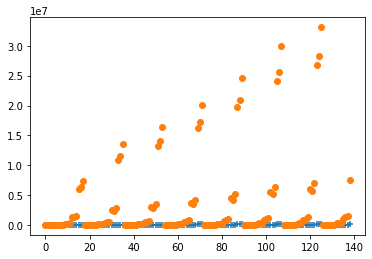

In [36]:
x = np.arange(0, len(flat_rmse_flat))
plt.scatter(x, flat_rmse_flat, marker = '+', label="Flat rmse")
plt.scatter(x, hh_rmse_flat, marker = 'o', label="HH rmse")
plt.plot()

[]

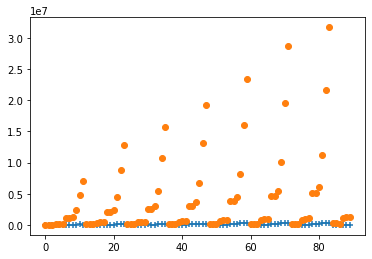

In [38]:
x = np.arange(0, len(hh_rmse_hh))
plt.scatter(x, flat_rmse_hh, marker = '+', label="Flat rmse")
plt.scatter(x, hh_rmse_hh, marker = 'o', label="HH rmse")
plt.plot()

In [14]:
def same_parameter(answers, correct_answer):
    error = np.abs(correct_answer-answers)
    max_error = np.amax(error)
    min_error = np.amin(error)
    true_values = np.full(len(answers), correct_answer)
    mse = mean_squared_error(true_values, answers, squared = False)
    error_dict = {'mse': mse, 'max': max_error, 'min': min_error, 'abs': np.mean(error)}
    
    return error_dict


In [15]:
print(flat_empty)
print(len(flat_empty))
print(hh_empty)
print(len(hh_empty))

NameError: name 'flat_empty' is not defined

In [ ]:
epsilon_error_dicts = {}
for idx, e in enumerate(epsilons):
    epsilon_error_dicts[e] = same_parameter(epsilons_res[idx], correct_answer)

In [ ]:
epsilon_error_dicts

In [ ]:
plt_name = 'flat_freq_epsilon'
dict_error_plot_epsilons(epsilon_error_dicts,plt_name, epsilons)

In [ ]:
n_error_dicts = {}
for idx, N in enumerate(n):
    n_error_dicts[N] = same_parameter(ns[idx], correct_answer)



In [ ]:
n_error_dicts

In [ ]:
print(n)
plt_name = 'flat_freq_N'
dict_error_plot_n(n_error_dicts,plt_name, n)

In [ ]:
"""
epsilons = np.array([2, 1.4, 1.2, 1, 0.8, 0.6, 0.5, 0.3])
n = np.array([32,128,256,512,1024,2048])
degrees = np.array([2,3,4])

flat_epsilon_2 = []
flat_epsilon_14 = []
flat_epsilon_12 = []
flat_epsilon_1 = []
flat_epsilon_08 = []
flat_epsilon_06 = []
flat_epsilon_05 = []
flat_epsilon_03 = []

flat_n_32 = []
flat_n_128 = []
flat_n_256 = []
flat_n_512 = []
flat_n_1024 = []
flat_n_2048 = []

flat_empty = []


for f in flat_files:
    print(f)
    if os.stat(f).st_size == 0:
        print('Empty')
        flat_empty.append(f)
    else:
        if 'e=2' in f:
            flat_epsilon_2.append(np.loadtxt(f, delimiter=','))
        if 'e=1.4' in f:
            flat_epsilon_14.append(np.loadtxt(f, delimiter=','))
        if 'e=1.4' in f:
            flat_epsilon_12.append(np.loadtxt(f, delimiter=','))
        if 'e=1.0' in f:
            flat_epsilon_1.append(np.loadtxt(f, delimiter=','))
        if 'e=0.8' in f:
            flat_epsilon_08.append(np.loadtxt(f, delimiter=','))
        if 'e=0.6' in f:
            flat_epsilon_06.append(np.loadtxt(f, delimiter=','))
        if 'e=0.5' in f:
            flat_epsilon_05.append(np.loadtxt(f, delimiter=','))
        if 'e=0.3' in f:
            flat_epsilon_03.append(np.loadtxt(f, delimiter=','))
        if 'N=32' in f:
            flat_n_32.append(np.loadtxt(f, delimiter=','))
        if 'N=128' in f:
            flat_n_128.append(np.loadtxt(f, delimiter=','))
        if 'N=256' in f:
            flat_n_256.append(np.loadtxt(f, delimiter=','))
        if 'N=512' in f:
            flat_n_512.append(np.loadtxt(f, delimiter=','))
        if 'N=1024' in f:
            flat_n_1024.append(np.loadtxt(f, delimiter=','))
        if 'N=2048' in f:
            flat_n_2048.append(np.loadtxt(f, delimiter=','))
        if 'N=256' in f and 'B=2' in f:
            print('a')
            n_256_hh_b2.append(load_range_queries_n_split(f, n_data_structures))
        if 'N=256' in f and 'B=3' in f:
            print('aa')
            n_256_hh_b3.append(load_range_queries_n_split(f, n_data_structures))
        if 'N=256' in f and 'B=4' in f:
            print('aaa')
            n_256_hh_b4.append(load_range_queries_n_split(f, n_data_structures))
        if 'N=512' in f and 'B=2' in f:
            print('b')
            n_512_hh_b2.append(load_range_queries_n_split(f, n_data_structures))
        if 'N=512' in f and 'B=3' in f:
            print('bb')
            n_512_hh_b3.append(load_range_queries_n_split(f, n_data_structures))
        if 'N=512' in f and 'B=4' in f:
            print('bbb')
            n_512_hh_b4.append(load_range_queries_n_split(f, n_data_structures))
        if 'N=1024' in f and 'B=2' in f:
            print('c')
            n_1024_hh_b2.append(load_range_queries_n_split(f, n_data_structures))
        if 'N=1024' in f and 'B=3' in f:
            print('cc')
            n_1024_hh_b3.append(load_range_queries_n_split(f, n_data_structures))
        if 'N=1024' in f and 'B=4' in f:
            print('ccc')
            n_1024_hh_b4.append(load_range_queries_n_split(f, n_data_structures))
        if 'N=2048' in f and 'B=2' in f:
            print('d')
            n_2048_hh_b2.append(load_range_queries_n_split(f, n_data_structures))        
        if 'N=2048' in f and 'B=3' in f:
            print('dd')
            n_2048_hh_b3.append(load_range_queries_n_split(f, n_data_structures))
        if 'N=2048' in f and 'B=4' in f:
            print('ddd')
            n_2048_hh_b4.append(load_range_queries_n_split(f, n_data_structures))
        
flat_epsilon_2 = np.array([item for sublist in flat_epsilon_2 for item in sublist])
flat_epsilon_14 = np.array([item for sublist in flat_epsilon_14 for item in sublist])
flat_epsilon_12 = np.array([item for sublist in flat_epsilon_12 for item in sublist])
flat_epsilon_1 = np.array([item for sublist in flat_epsilon_1 for item in sublist])
flat_epsilon_08 = np.array([item for sublist in flat_epsilon_08 for item in sublist])
flat_epsilon_06 = np.array([item for sublist in flat_epsilon_06 for item in sublist])
flat_epsilon_05 = np.array([item for sublist in flat_epsilon_05 for item in sublist])
flat_epsilon_03 = np.array([item for sublist in flat_epsilon_03 for item in sublist])


flat_n_32 = np.array([item for sublist in flat_n_32 for item in sublist])
flat_n_128 = np.array([item for sublist in flat_n_128 for item in sublist])
flat_n_256 = np.array([item for sublist in flat_n_256 for item in sublist])
flat_n_512 = np.array([item for sublist in flat_n_512 for item in sublist])
flat_n_1024 = np.array([item for sublist in flat_n_1024 for item in sublist])
flat_n_2048 = np.array([item for sublist in flat_n_2048 for item in sublist])

flat_epsilons_res = [flat_epsilon_2 ,flat_epsilon_14, flat_epsilon_1, flat_epsilon_08, flat_epsilon_03]
flat_ns = [flat_n_32, flat_n_128, flat_n_512, flat_n_2048]
"""